In [1]:
# Importing all tools that could be necessary for the tasks
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & \begin{cases}
w h_2 & 
\text{if }l_2 = 1  \\
b & \text{if }l_2 = 0 
\end{cases} \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_{1}& = & \begin{cases}
w h_1 & 
\text{if }l_1 = 1  \\
b & \text{if }l_1 = 0 
\end{cases} \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

To solve the model for period 2, we must define the various functions making up the model. This includes consumtion, utility, bequest and lastly value for both periods.

In [4]:
# Defining the consumption function, utility function, bequest function and maximization problem for period 2.
def c(w,b,h,l):
    if l==1:
        return w*h
    else:
        return b

def utility(w,b,h,l,rho):
    return c(w,b,h,l)**(1-rho)/(1-rho)

def bequest(l,gamma):
    return gamma*l

def v2(w,b,h2,l2,rho,gamma):
    return utility(w,b,h2,l2,rho)-bequest(l2,gamma)

In [5]:
# Defining maximization problem for period 1 for later use
def v1(w,b,h1,l1,Delta,rho,beta,v2_interp):
    
    # a. v2 value if not working in period 1
    h2_nowork = h1 + l1 + 0
    v2_nowork = v2_interp([h2_nowork])[0]
    
    # b. v2 value if working in period 1
    h2_work = h1 + 1 + Delta
    v2_work = v2_interp([h2_work])[0]
    
    # c. Expected value of v2
    v2 = 0.5 * v2_nowork + 0.5 * v2_work
    
    # d. Total value
    return utility(w,b,h1,l1,rho) - bequest(l1,gamma) + beta*v2

We then go on to solving the maximization problem for period 2. This will let us illustrate the chosen consumption, value and labor supply based on human capital of the consumer.

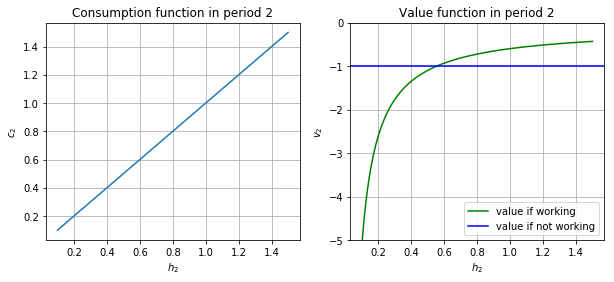

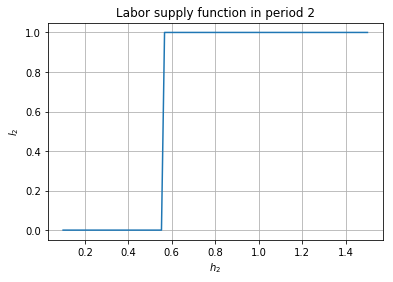

In [6]:
# We then define the function for solving the maximization problem for period 2
def solve_period_2(rho,gamma,Delta):
    
    # a. grids
    h2_vec = np.linspace(0.1,1.5,100)
    v2_vec = np.empty(100)
    c2_vec = np.empty(100)
    l2_vec = np.empty(100)
    

    # b. solve for each h2 in grid
    for i,h2 in enumerate(h2_vec):
        
        # i. Deciding whether to work or not to work depending on value
        if (v2(w,b,h2,1,rho,gamma) > v2(w,b,h2,0,rho,gamma)) == True:
            l2_vec[i] = 1
        else: 
            l2_vec[i] = 0
    
        v2_vec[i] = v2(w,b,h2,l2_vec[i],rho,gamma)
        
        # ii. objective
        obj = lambda c2: -v2(w,b,h2_vec,0,rho,gamma)

        # iii. initial value (consume half)
        x0 = h2/2

        # iv. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[0.1,h2])
        
        # v. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return h2_vec,v2_vec,c2_vec,l2_vec

# solve
h2_vec,v2_vec,c2_vec,l2_vec = solve_period_2(rho,gamma,Delta)

# illustration
# Plotting consumption as a function of human capital for period 2
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(h2_vec,c2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$c_2$')
ax.set_title('Consumption function in period 2')

# Plotting value as a function of human capital depending on whether consumer chooses to work or not
ax = fig.add_subplot(1,2,2)
ax.plot(h2_vec,v2(w,b,h2_vec,1,rho,gamma),color='green',label='value if working')
ax.axhline(y=v2(w,b,h2_vec,0,rho,gamma),color='blue',label='value if not working')
ax.legend(loc='lower right')
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$v_2$')
ax.set_title('Value function in period 2')
ax.set_ylim([-5,0]);

# Plotting labor supply as a function of human capital
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h2_vec,l2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$l_2$')
ax.set_title('Labor supply function in period 2');

We see that a consumer will only choose to work in period 2 if the human capital is above approximately 0.55

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

First we define a variable holding the optimal value of period 2 to include in the maximization of period 1.

In [7]:
# Variable for including value from period 2 in period 1
v2_interp = interpolate.RegularGridInterpolator([h2_vec], v2_vec,
                                                bounds_error=False,fill_value=None)

Next we go on to defining the solution for the maximization problem of period 1 for use in illustrating consumption, value and labor supply as a function of human capital in period 1.

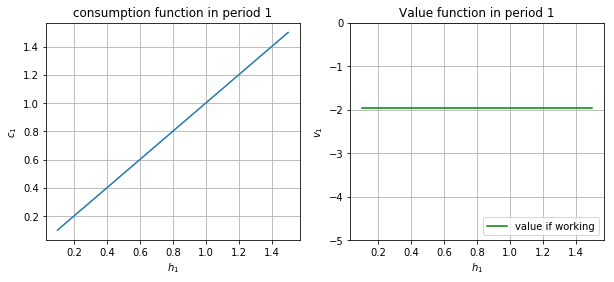

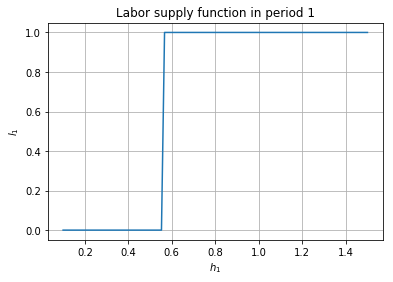

In [8]:
# Defining the solution for maximization in period 1
def solve_period_1(rho,beta,Delta,v2_interp):

    # a. grids
    h1_vec = np.linspace(0.1,1.5,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    l1_vec = np.empty(100)
    
    # b. solve for each h1 in grid
    for i,h1 in enumerate(h1_vec):
        
        # Choosing whether to work or not
        if (v1(w,b,h1,1,Delta,rho,beta,v2_interp) > v1(w,b,h1,0,Delta,rho,beta,v2_interp)) == True:
            l1_vec[i] = 1
        else: 
            l1_vec[i] = 0
    
        v1_vec[i] = v1(w,b,h1,l1_vec[i],Delta,rho,beta,v2_interp)
        
        # i. objective
        obj = lambda c1: -v1(w,b,h1,0,Delta,rho,beta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = h1*1/2
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[0.1,h1])
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
     
    return h1_vec,v1_vec,c1_vec,l1_vec

# solve
h1_vec,v1_vec,c1_vec,l1_vec = solve_period_1(rho,beta,Delta,v2_interp)

# illustrate
# Consumption as a function of human capital
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(h1_vec,c1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')

# Value as a function of human capital
ax = fig.add_subplot(1,2,2)
ax.plot(h1_vec,v1_vec,color='green',label='value if working')
ax.legend(loc='lower right')
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$v_1$')
ax.set_title('Value function in period 1')
ax.set_ylim([-5,0]);

# Labor supply as a function of human capital
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h1_vec,l1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$l_1$')
ax.set_title('Labor supply function in period 1');

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

To figure out if the worker will work if the wage is lower than the unemployment benefit, we redefine the wage and run the solution to the maximization problem again.

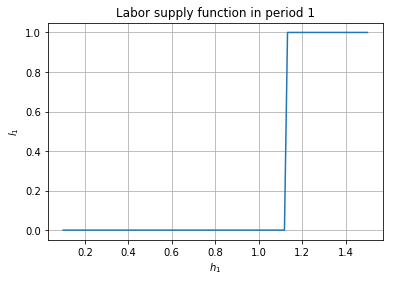

In [9]:
# Redefining the wage to make it lower than the unemployment benefits
w_under=0.99

# Defining the solution function with the new wage variable
def solve_period_1_w_under(rho,beta,Delta,v2_interp):

    # a. grids
    v1_vec = np.empty(100)
    l1_vec = np.empty(100)
    
    # b. solve for each h1 in grid
    for i,h1 in enumerate(h1_vec):
        
        # Choosing whether to work or not
        if (v1(w_under,b,h1,1,Delta,rho,beta,v2_interp) > v1(w_under,b,h1,0,Delta,rho,beta,v2_interp)) == True:
            l1_vec[i] = 1
        else: 
            l1_vec[i] = 0
    
        v1_vec[i] = v1(w_under,b,h1,l1_vec[i],Delta,rho,beta,v2_interp)
        
     
    return v1_vec,l1_vec

# solve
v1_vec,l1_vec = solve_period_1_w_under(rho,beta,Delta,v2_interp)

# Plotting the labor supply as a function of human capital
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h1_vec,l1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$l_1$')
ax.set_title('Labor supply function in period 1');

As we see, the worker will still choose to work if the human capital is high enough. However, as illustrated, the human capital does need to be much higher if the wage is just a fraction lower than the unemployment benefits for the worker to choose to work.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [10]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

We start out by defining all variables as sympy symbols for illustrating the mathmatical progression and solution for equilibrium values in the model.

In [11]:
# Defining variables as symbols

alpha = sm.symbols('alpha')
h = sm.symbols('h')
b = sm.symbols('b')
phi = sm.symbols('phi')
gamma = sm.symbols('gamma')
it = sm.symbols('i_t')
yt = sm.symbols('y_t')
pit = sm.symbols('pi_t')
vt = sm.symbols('v_t')
st = sm.symbols('s_t')
ylag = sm.symbols('y_t-1')
pilag = sm.symbols('pi_t-1')
vlag = sm.symbols('v_t-1')
slag = sm.symbols('s_t-1')

# Enabling nice printing
sm.init_printing(use_unicode=True)

We then need to define the AD function and SRAS function as given above.

In [12]:
# Stating the AD-function
AD = sm.Eq((vt-(1+b*alpha)*yt)/(h*alpha),pit)
AD

In [13]:
# Stating the SRAS-function
SRAS = sm.Eq(pilag+gamma*yt-phi*gamma*ylag+st-phi*slag,pit)
SRAS

As both functions express the inflation gap, we can set the two equal and solve for the output gap to find the equilibrium value of the output gap.

In [14]:
# Setting the two functions equal
ADSRAS = sm.Eq((vt-(1+b*alpha)*yt)/(h*alpha),pilag+gamma*yt-phi*gamma*ylag+st-phi*slag)
ADSRAS

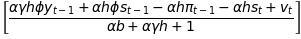

In [15]:
# Solving for the output gap
solveyt=sm.solve(ADSRAS,yt)
solveyt

Next we substitue the found function for the equilibrium value of the output gap into the AD-function to find the equilibrium value of the inflation gap.

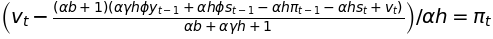

In [16]:
# Substituting equilibrium value of output gap into AD-function to find inflation gap
solvepit=AD.subs(yt,solveyt[0])
solvepit

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

We start out by defining the AD-function,the SRAS function and the needed variables.

In [17]:
# Defining the AD-function
def AD(vt,yt,b,h,alpha):
    return (vt-yt*(alpha*b+1))/(alpha*h)

# Defining the SRAS-function
def SRAS(gamma,phi,ylag,yt,slag,pilag,st):
    return st+pilag+gamma*yt-phi*slag-gamma*phi*ylag

In [18]:
# defining the variables
ylag,pilag,vt,st,slag = 0,0,0,0,0
alpha = 5.76
h = 0.5
b = 0.5
phi = 0
gamma = 0.075
v_shock = 0.1
yt = np.linspace(-0.5,0.5,100)

Next we define the line for plotting in a graph to illustrate the effect of a shock in demand.

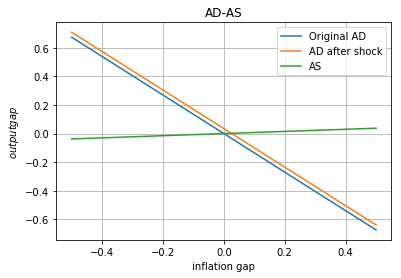

In [19]:
# Defining the lines for the graph
ADline = AD(vt,yt,b,h,alpha)
ADlineShock = AD(v_shock,yt,b,h,alpha)
ASline = SRAS(gamma,phi,ylag,yt,slag,pilag,st)

# Plotting the AD lines and the AS line
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(yt, ADline,label='Original AD')
ax.plot(yt, ADlineShock, label='AD after shock')
ax.plot(yt, ASline, label='AS')
ax.set_xlabel(r'inflation gap')
ax.set_ylabel('$output gap$')
ax.legend(loc='upper right')
ax.set_title('AD-AS')
ax.grid()
plt.show()

We see that a demand shock clearly shifts the accumulated demand to the right, which in turn gives a new equilibrium.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [20]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

To see how the economy evolves as a function of demand- and supply shocks, we first must define the functions for each of the shocks.

In [21]:
# Defining the parameters
delta = 0.8
omega = 0.15

# Defining the demand- and supplyshock functions
def vtar1(delta,vlag,xt):
    return delta*vlag+xt

def star1(omega,slag,ct):
    return omega*slag+ct

Next we define the equilibrium functions for the output gap and inflation gap.

In [22]:
# Equlibrium value of output gap
def yt_eq(alpha,gamma,h,phi,b,ylag,slag,st,vt):
    return (alpha*gamma*h*phi*ylag+alpha*h*phi*slag-alpha*h*pilag-alpha*h*st+vt)/(alpha*b+alpha*gamma*h+1)

# Equilibrium value of inflation gap
def pit_eq(alpha,gamma,h,phi,b,ylag,slag,st,vt):
    return (vt-yt_eq(alpha,gamma,h,phi,b,ylag,slag,st,vt))/(alpha*h)

Lastly we forecast values for equilibrium values for both output gap and inflation gap, based on the necessary variables. This allows us to illustrate the forcsted values and the thereby the evolution of the economy.

In [23]:
# Setting the forecast to 10 periods and creating empty vectors to fill
T=10
pitv =[0]
ytv =[0]
stv =[0]
vtv =[0]
ctv =np.zeros(T)
xtv =np.zeros(T)
xtv[1]=0.1

# Filling out the vectors with values dependant on the relevant variables
for t in range (1,T):
    stv.append(star1(omega,stv[t-1],ctv[t]))
    vtv.append(vtar1(delta,vtv[t-1],xtv[t]))
    ytv.append(yt_eq(alpha,gamma,h,phi,b,ytv[t-1],stv[1-t],stv[t],vtv[t]))
    pitv.append(pit_eq(alpha,gamma,h,phi,b,ytv[t-1],stv[1-t],stv[t],vtv[t]))

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


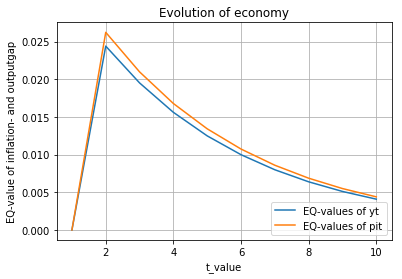

In [24]:
# Creating a timeframe for use as x-axis
t_value = np.linspace(1,T,T)

# Plotting the equilibrium vlues of both output gap and inflation gap for the next 10 periods.
fig = plt.figure()
plt.axes()
ax = fig.add_subplot(1,1,1)
ax.plot(t_value, ytv, label='EQ-values of yt')
ax.plot(t_value, pitv, label='EQ-values of pit')
ax.set_xlabel('t_value')
ax.set_ylabel('EQ-value of inflation- and outputgap')
ax.set_title('Evolution of economy')
ax.legend(loc='lower right')
ax.grid()

As seen above, the equilibrium values will rise in the first couple of periods and then decline once again.

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [25]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

We start out by defining the new parameters and the stochastic shocks in addition to resetting the vectors for the variables for simulating the equilibrium values over 1000 periods.

In [26]:
# a. true parameters in the data generating process
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

# b. simulate observed dataset
np.random.seed(2019); # set the seed
t_sim = 1000;

# stochastic variables nd vectors
pitv =[0]
ytv =[0]
stv =[0]
vtv =[0]
ct_stoc = np.random.normal(loc=0.0,scale=par['sigma_c'],size=t_sim)
xt_stoc = np.random.normal(loc=0.0,scale=par['sigma_x'],size=t_sim)

# creating the equilibrium values
for t in range (1,t_sim):
    stv.append(star1(omega,stv[t-1],ct_stoc[t]))
    vtv.append(vtar1(delta,vtv[t-1],xt_stoc[t]))
    ytv.append(yt_eq(alpha,gamma,h,phi,b,ytv[t-1],stv[1-t],stv[t],vtv[t]))
    pitv.append(pit_eq(alpha,gamma,h,phi,b,ytv[t-1],stv[1-t],stv[t],vtv[t]))

We then go on to plot the equilibrium values as a scatterplot over the 1000 periods.

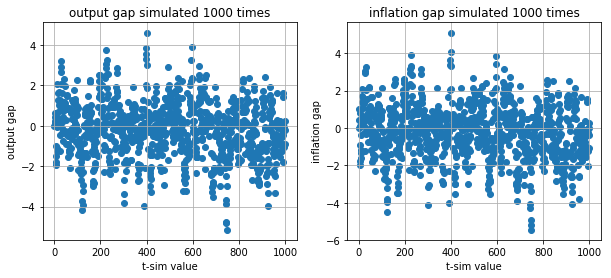

In [27]:
# Creating a timeframe for the x-axis
t_sim_value = np.linspace(1,t_sim,t_sim)

# Illustrating the equilibrium values for the output gap
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(t_sim_value,ytv)
ax.grid(True)
ax.set_xlabel('t-sim value')
ax.set_ylabel('output gap')
ax.set_title('output gap simulated 1000 times')

# Illustrating the equilibrium values for the inflation gap
ax = fig.add_subplot(1,2,2)
ax.scatter(t_sim_value,pitv)
ax.grid(True)
ax.set_xlabel('t-sim value')
ax.set_ylabel('inflation gap')
ax.set_title('inflation gap simulated 1000 times');

We then go on to calculating the variance and correlations of the output gap and inflation gap using numpy.

In [28]:
# Variance of output gap
var_yt = np.var(ytv)
# Variance of inflation gap
var_pit = np.var(pitv)
# Autocorrelation of inflation gap
cor_pit = np.corrcoef(pitv[1:t_sim],pitv[0:-1])
# Autocorrelation of output gap
cor_yt = np.corrcoef(ytv[1:t_sim],ytv[0:-1])
# Correlation between output gap and inflation gap
cor_ytpit = np.corrcoef(ytv,pitv)

# Printing the results
print(f'variance of yt is {var_yt}')
print(f'variance of pit is {var_pit}')
print(f'autocorrelation of pit is {cor_pit}')
print(f'autocorrelation of yt is {cor_yt}')
print(f'correlation between pit and yt is {cor_ytpit}')

variance of yt is 1.8999010368515332
variance of pit is 2.1797771543103277
autocorrelation of pit is [[1.         0.79317795]
 [0.79317795 1.        ]]
autocorrelation of yt is [[1.         0.78867755]
 [0.78867755 1.        ]]
correlation between pit and yt is [[1.         0.99028573]
 [0.99028573 1.        ]]


**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [29]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

As the simulation is run above, we can plot the budget shares for each good across agents directly.

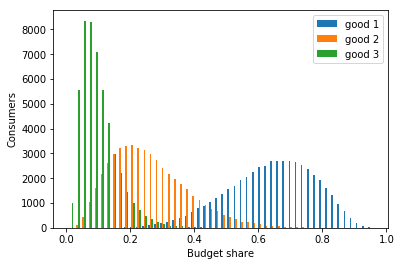

In [30]:
plt.hist(betas, bins=50, label=['good 1','good 2', 'good 3'])
plt.xlabel('Budget share')
plt.ylabel('Consumers')
plt.legend(loc='upper right');

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

**Question 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?